# Experiment 011

In this experiment, we try integrating the block landing model into the Tetris emulator to see if that improves the predictions.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it), default=-1)

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = torch.tensor(boards[-2]) # Ignore all boards except the last two
        y = torch.tensor(boards[-1], dtype=torch.long)
        return x, y
        

In [3]:
train_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "train"))
test_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "test"))
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 22, 10]) torch.int32
torch.Size([4, 22, 10]) torch.int64


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class TetrisModel(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of int32 of shape (batch_size, height, width). height = 22 and width = 10 are the dimensions of the game
           board. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: Tensor of float32 of shape (batch_size, height, width), logits for the new cells. Probabilities close to 0 (negative logits)
             correspond to empty cells, and probabilities close to 1 (positive logits) correspond to blocks.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3, padding=1)
        self.conv1 = nn.Conv2d(10, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [6]:
class BlockLandingModel(nn.Module):
    """Predicts whether a block has landed.

    Inputs:
        x: Tensor of int32 of shape (batch_size, seq_length, height, width) or (seq_length, height, width).
           height = 22 and width = 10 are the dimensions of the game board. seq_length = 2 is the number
           of game board inputs. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: float32 scalar, logit for block landing prediction.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.lin = nn.Linear(160, 1)

    def forward(self, x):
        assert (x.dim() in (3, 4)), f"Expected input to be 3-D or 4-D but received {x.dim()}-D tensor."
        batched = x.dim() == 4
        if not batched:
            x = x.unsqueeze(0)
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes, which adds an extra dimension
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x = x[-1] # Just take the last board state in the sequence; channels are now dim 1
        x = self.conv0(x)                  # (22, 10) -> (22, 10)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)                  # (22, 10) -> (22, 10)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # (22, 10) -> (11,  5)
        x = self.conv2(x)                  # (11,  5) -> (11,  5)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # (11,  5) -> ( 5,  2)
        x = torch.flatten(x, start_dim=1)
        logits = self.lin(x).squeeze(-1)
        if not batched:
            logits = logits.squeeze(0)
        return logits

In [7]:
class ModelWithBlockLandingModel(nn.Module):
    def __init__(self, block_landing_model):
        super().__init__()
        self.block_landing_model = block_landing_model
        self.conv0 = nn.Conv2d(2, 10, 3, padding=1)
        self.conv1 = nn.Conv2d(10, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(11, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [8]:
block_landing_model = BlockLandingModel().to(device)
block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
block_landing_model.requires_grad_(False)

model = ModelWithBlockLandingModel(block_landing_model).to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

ModelWithBlockLandingModel(
  (block_landing_model): BlockLandingModel(
    (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin): Linear(in_features=160, out_features=1, bias=True)
  )
  (conv0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(11, 2, kernel_size=(1, 1), stride=(1, 1))
)
Predicted states: tensor([[[0.3980, 0.3973, 0.3957, 0.3955, 0.3974, 0.3

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    epoch_loss = 0.0
    cell_accuracy = 0.0
    board_accuracy = 0.0

    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        classes = torch.argmax(pred, dim=1)
        cell_accuracy += (classes == y).type(torch.float).mean().item()
        board_accuracy += (classes == y).all(-1).all(-1).type(torch.float).mean().item()
    
    epoch_loss /= num_batches
    cell_accuracy /= num_batches
    board_accuracy /= num_batches
    return {
        "loss": epoch_loss,
        "acc": cell_accuracy,
        "acc_board": board_accuracy
    }


def test_loop(dataloader, model, loss_fn):
    model.eval()

    epoch_loss = 0.0
    cell_accuracy = 0.0
    board_accuracy = 0.0

    num_batches = len(dataloader)
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            epoch_loss += loss_fn(pred, y).item()
            classes = torch.argmax(pred, dim=1)
            cell_accuracy += (classes == y).type(torch.float).mean().item()
            board_accuracy += (classes == y).all(-1).all(-1).type(torch.float).mean().item()

    epoch_loss /= num_batches
    cell_accuracy /= num_batches
    board_accuracy /= num_batches
    print(f"Test Error: \n Accuracy: {(100*cell_accuracy):>0.1f}%, Board accuracy: {(100*board_accuracy):>0.1f}%, Avg loss: {epoch_loss:>8f} \n")
    return {
        "loss": epoch_loss,
        "acc": cell_accuracy,
        "acc_board": board_accuracy
    }

In [10]:
def train(model, learning_rate=1e-1, batch_size=4, epochs=100):
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_011")
    log_subdir = os.path.join(log_dir, f'{model.__class__.__name__}_lr_{str(learning_rate).replace(".", "_")}_bs_{batch_size}_ep_{epochs}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}')
    tb = SummaryWriter(log_subdir)

    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Cell accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Board accuracy/train", train_metrics["acc_board"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Cell accuracy/test", test_metrics["acc"], t)
        tb.add_scalar("Board accuracy/test", test_metrics["acc_board"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            if weight.grad is not None:
                tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

    return {
        "train_accuracy": train_metrics["acc_board"],
        "test_accuracy": test_metrics["acc_board"]
    }

In [43]:
from scipy.stats import ttest_ind

repeats = 10

baseline_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

model_with_block_landing_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(10):
    # Train baseline
    baseline_model = TetrisModel().to(device)
    repeat_results = train(baseline_model)
    baseline_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    baseline_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]

    # Train new architecture
    block_landing_model = BlockLandingModel().to(device)
    block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
    block_landing_model.requires_grad_(False)
    model_with_block_landing = ModelWithBlockLandingModel(block_landing_model).to(device)
    repeat_results = train(model_with_block_landing)
    model_with_block_landing_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    model_with_block_landing_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Baseline results:")
print(f"Train accuracy mean {baseline_results['train_accuracy'].mean():.5f}, std {baseline_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {baseline_results['test_accuracy'].mean():.5f}, std {baseline_results['test_accuracy'].std():.5f}")
print()
print(f"Competitor results:")
print(f"Train accuracy mean {model_with_block_landing_results['train_accuracy'].mean():.5f}, std {model_with_block_landing_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {model_with_block_landing_results['test_accuracy'].mean():.5f}, std {model_with_block_landing_results['test_accuracy'].std():.5f}")

print("Performing t-tests...")
train_ttest = ttest_ind(baseline_results["train_accuracy"], model_with_block_landing_results["train_accuracy"], equal_var=False)
test_ttest = ttest_ind(baseline_results["test_accuracy"], model_with_block_landing_results["test_accuracy"], equal_var=False)

print("Training t-test results:")
print(train_ttest)

print("Test t-test results:")
print(test_ttest)

Epoch 0
-------------------------------
loss: 0.659013  [    4/  237]
loss: 0.348744  [   84/  237]
loss: 0.298675  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.296648 

Epoch 1
-------------------------------
loss: 0.430170  [    4/  237]
loss: 0.286383  [   84/  237]
loss: 0.326050  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.260598 

Epoch 2
-------------------------------
loss: 0.196686  [    4/  237]
loss: 0.239681  [   84/  237]
loss: 0.159825  [  164/  237]
Test Error: 
 Accuracy: 96.1%, Board accuracy: 0.0%, Avg loss: 0.119529 

Epoch 3
-------------------------------
loss: 0.097785  [    4/  237]
loss: 0.075041  [   84/  237]
loss: 0.104047  [  164/  237]
Test Error: 
 Accuracy: 95.6%, Board accuracy: 0.0%, Avg loss: 0.086735 

Epoch 4
-------------------------------
loss: 0.061583  [    4/  237]
loss: 0.054794  [   84/  237]
loss: 0.079892  [  164/  237]
Test Error: 
 Accuracy: 96.0%, Board accuracy: 0.0%, A

There is not a big difference between the results for the two models. Notably, the test board accuracy curves are very spiky for both, suggesting that some other aspect of the model or training process is being a bottleneck. Let's try altering the Tetris emulator architecture and training process before introducing block landing predictions into the mix.

# Improving existing architecture/training

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
print(f"{TetrisModel.__name__} has {count_parameters(TetrisModel())} parameters.")
print(f"{BlockLandingModel.__name__} has {count_parameters(BlockLandingModel())} parameters.")
print(f"{ModelWithBlockLandingModel.__name__} has {count_parameters(ModelWithBlockLandingModel(block_landing_model))} parameters.")

TetrisModel has 1232 parameters.
BlockLandingModel has 5201 parameters.
ModelWithBlockLandingModel has 1234 parameters.


The Tetris model has fewer parameters than the block landing model, which seems a bit mad. Let's consider increasing the capacity of the Tetris model.

## Batch normalization

In [13]:
class TetrisModelWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(10)
        self.conv1 = nn.Conv2d(10, 10, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.norm2 = nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [14]:
model = TetrisModelWithBatchNorm().to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

TetrisModelWithBatchNorm(
  (conv0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm0): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
  (norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1))
)
Predicted states: tensor([[[0.3957, 0.3027, 0.3465, 0.3465, 0.3465, 0.3465, 0.3465, 0.3465,
          0.3088, 0.3554],
         [0.3562, 0.3178, 0.3540, 0.3540, 0.3540, 0.3540, 0.3540, 0.3540,
          0.3496, 0.3411],
         [0.3432, 0.3919, 0.3572, 0.3572, 0.3572, 0.3572, 0.3572, 0.3572,
          0.3314, 0.3841],
         [0.3432, 0.3919, 0.3572, 0.3572, 0.3572, 0.3572, 0.3572, 0.3572,
          0.3314, 0.3841],
   

In [19]:
from scipy.stats import ttest_ind

repeats = 10

baseline_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

competitor_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(10):
    # Train baseline
    baseline_model = TetrisModel().to(device)
    repeat_results = train(baseline_model)
    baseline_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    baseline_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]

    # Train new architecture
    competitor_model = TetrisModelWithBatchNorm().to(device)
    repeat_results = train(competitor_model)
    competitor_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    competitor_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Baseline results:")
print(f"Train accuracy mean {baseline_results['train_accuracy'].mean():.5f}, std {baseline_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {baseline_results['test_accuracy'].mean():.5f}, std {baseline_results['test_accuracy'].std():.5f}")
print()
print(f"Competitor results:")
print(f"Train accuracy mean {competitor_results['train_accuracy'].mean():.5f}, std {competitor_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {competitor_results['test_accuracy'].mean():.5f}, std {competitor_results['test_accuracy'].std():.5f}")
print()

print("Performing t-tests...")
train_ttest = ttest_ind(baseline_results["train_accuracy"], competitor_results["train_accuracy"], equal_var=False)
test_ttest = ttest_ind(baseline_results["test_accuracy"], competitor_results["test_accuracy"], equal_var=False)

print("Training t-test results:")
print(train_ttest)

print("Test t-test results:")
print(test_ttest)

Epoch 0
-------------------------------
loss: 0.571686  [    4/  237]
loss: 0.226984  [   84/  237]
loss: 0.211745  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.217376 

Epoch 1
-------------------------------
loss: 0.243772  [    4/  237]
loss: 0.249188  [   84/  237]
loss: 0.184067  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.151197 

Epoch 2
-------------------------------
loss: 0.171259  [    4/  237]
loss: 0.114019  [   84/  237]
loss: 0.133173  [  164/  237]
Test Error: 
 Accuracy: 95.8%, Board accuracy: 0.0%, Avg loss: 0.120610 

Epoch 3
-------------------------------
loss: 0.076624  [    4/  237]
loss: 0.101103  [   84/  237]
loss: 0.125112  [  164/  237]
Test Error: 
 Accuracy: 95.6%, Board accuracy: 0.0%, Avg loss: 0.096951 

Epoch 4
-------------------------------
loss: 0.103440  [    4/  237]
loss: 0.088932  [   84/  237]
loss: 0.076297  [  164/  237]
Test Error: 
 Accuracy: 96.3%, Board accuracy: 0.0%, A

The results are clearly much better with batch normalization. The board accuracy curves increase much more sharply and all the curves are somewhat less spiky. The training curves are substantially less spiky, but the test curves show only a modest reduction in spikiness. Overall, it seems a good idea to keep the batch normalization.

The test board accuracy of the model with batch normalization peaks at 91.67% quite reliably, and the training board accuracy peaks at 95.42%.

## Model capacity

Let's now compare the Tetris model with the block landing model in terms of number of parameters and where most of the parameters are in the architecture. We'll increase the Tetris model parameters in similar places to where the block landing model has more parameters, and see if this improves the Tetris model.

In [15]:
model = TetrisModelWithBatchNorm()
print("Parameters in Tetris model with batch norm:")
print(f"Total: {count_parameters(model)}")
for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name}: {p.numel()}")

Parameters in Tetris model with batch norm:
Total: 1292
conv0.weight: 180
conv0.bias: 10
norm0.weight: 10
norm0.bias: 10
conv1.weight: 900
conv1.bias: 10
norm1.weight: 10
norm1.bias: 10
conv2.weight: 100
conv2.bias: 10
norm2.weight: 10
norm2.bias: 10
conv3.weight: 20
conv3.bias: 2


In [16]:
model = BlockLandingModel()
print("Parameters in block landing model:")
print(f"Total: {count_parameters(model)}")
for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name}: {p.numel()}")

Parameters in block landing model:
Total: 5201
conv0.weight: 288
conv0.bias: 16
norm0.weight: 16
norm0.bias: 16
conv1.weight: 2304
conv1.bias: 16
norm1.weight: 16
norm1.bias: 16
conv2.weight: 2304
conv2.bias: 16
norm2.weight: 16
norm2.bias: 16
lin.weight: 160
lin.bias: 1


In [17]:
class BiggerTetrisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [18]:
model = BiggerTetrisModel().to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

BiggerTetrisModel(
  (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
)
Predicted states: tensor([[[0.3069, 0.3241, 0.3297, 0.3587, 0.3564, 0.3720, 0.3594, 0.3665,
          0.3514, 0.3559],
         [0.2519, 0.3568, 0.4270, 0.3878, 0.3418, 0.3422, 0.3461, 0.3682,
          0.3395, 0.3572],
         [0.2735, 0.3525, 0.2275, 0.1898, 0.2551, 0.2936, 0.3069, 0.2949,
          0.3097, 0.3183],
         [0.3159, 0.3261, 0.3360, 0.3914, 0.3238, 0.3540, 0.2786, 0.3634,
          0.3423, 0.3

In [19]:
model = BiggerTetrisModel()
print("Parameters in bigger Tetris model:")
print(f"Total: {count_parameters(model)}")
for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name}: {p.numel()}")

Parameters in bigger Tetris model:
Total: 5074
conv0.weight: 288
conv0.bias: 16
norm0.weight: 16
norm0.bias: 16
conv1.weight: 2304
conv1.bias: 16
norm1.weight: 16
norm1.bias: 16
conv2.weight: 2304
conv2.bias: 16
norm2.weight: 16
norm2.bias: 16
conv3.weight: 32
conv3.bias: 2


In [32]:
from scipy.stats import ttest_ind

repeats = 10

competitor_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(10):
    # Train new architecture
    competitor_model = BiggerTetrisModel().to(device)
    repeat_results = train(competitor_model)
    competitor_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    competitor_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Baseline results:")
print(f"Train accuracy mean {baseline_results['train_accuracy'].mean():.5f}, std {baseline_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {baseline_results['test_accuracy'].mean():.5f}, std {baseline_results['test_accuracy'].std():.5f}")
print()
print(f"Competitor results:")
print(f"Train accuracy mean {competitor_results['train_accuracy'].mean():.5f}, std {competitor_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {competitor_results['test_accuracy'].mean():.5f}, std {competitor_results['test_accuracy'].std():.5f}")
print()

print("Performing t-tests...")
train_ttest = ttest_ind(baseline_results["train_accuracy"], competitor_results["train_accuracy"], equal_var=False)
test_ttest = ttest_ind(baseline_results["test_accuracy"], competitor_results["test_accuracy"], equal_var=False)

print("Training t-test results:")
print(train_ttest)

print("Test t-test results:")
print(test_ttest)

Epoch 0
-------------------------------
Test Error: 
 Accuracy: 99.6%, Board accuracy: 62.8%, Avg loss: 0.049743 

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 81.1%, Avg loss: 0.023353 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 86.1%, Avg loss: 0.016257 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 81.7%, Avg loss: 0.015042 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 89.4%, Avg loss: 0.011454 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 90.0%, Avg loss: 0.010164 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 91.7%, Avg loss: 0.010128 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.4%, Board accuracy: 47.8%, Avg loss: 0.022848 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board acc

The peak performance of `BiggerTetrisModel` is about the same as that of `TetrisModelWithBatchNorm`, but all the curves - including the test loss and test board accuracy - are significantly less spiky. This suggests we should keep the larger model.

# Re-adding the block landing model

Now that we've tried out some architecture changes, let's re-add the block landing model and see if it now improves the predictions.

In [20]:
class BiggerTetrisModelWithBlockLandingAtLevel2(nn.Module):
    def __init__(self, block_landing_model):
        super().__init__()
        self.block_landing_model = block_landing_model
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(17, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [21]:
class BiggerTetrisModelWithBlockLandingAtLevel1(nn.Module):
    def __init__(self, block_landing_model):
        super().__init__()
        self.block_landing_model = block_landing_model
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(17, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [22]:
class BiggerTetrisModelWithBlockLandingAtLevel0(nn.Module):
    def __init__(self, block_landing_model):
        super().__init__()
        self.block_landing_model = block_landing_model
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(17, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [23]:
block_landing_model = BlockLandingModel().to(device)
block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
block_landing_model.requires_grad_(False)

model = BiggerTetrisModelWithBlockLandingAtLevel0(block_landing_model).to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

BiggerTetrisModelWithBlockLandingAtLevel0(
  (block_landing_model): BlockLandingModel(
    (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin): Linear(in_features=160, out_features=1, bias=True)
  )
  (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(17, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [41]:
repeats = 10
epochs = 100

block_landing_model = BlockLandingModel().to(device)
block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
block_landing_model.requires_grad_(False)

level_2_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

level_1_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

level_0_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(10):
    # Train level 2 architecture
    level_2_model = BiggerTetrisModelWithBlockLandingAtLevel2(block_landing_model).to(device)
    repeat_results = train(level_2_model, epochs=epochs)
    level_2_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    level_2_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]

    # Train level 1 architecture
    level_1_model = BiggerTetrisModelWithBlockLandingAtLevel1(block_landing_model).to(device)
    repeat_results = train(level_1_model, epochs=epochs)
    level_1_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    level_1_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]

    # Train level 0 architecture
    level_0_model = BiggerTetrisModelWithBlockLandingAtLevel0(block_landing_model).to(device)
    repeat_results = train(level_0_model, epochs=epochs)
    level_0_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    level_0_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Level 2 results:")
print(f"Train accuracy mean {level_2_results['train_accuracy'].mean():.5f}, std {level_2_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {level_2_results['test_accuracy'].mean():.5f}, std {level_2_results['test_accuracy'].std():.5f}")
print()

print(f"Level 1 results:")
print(f"Train accuracy mean {level_1_results['train_accuracy'].mean():.5f}, std {level_1_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {level_1_results['test_accuracy'].mean():.5f}, std {level_1_results['test_accuracy'].std():.5f}")
print()

print(f"Level 0 results:")
print(f"Train accuracy mean {level_0_results['train_accuracy'].mean():.5f}, std {level_0_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {level_0_results['test_accuracy'].mean():.5f}, std {level_0_results['test_accuracy'].std():.5f}")
print()

Epoch 0
-------------------------------
Test Error: 
 Accuracy: 97.1%, Board accuracy: 42.8%, Avg loss: 0.075131 

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.1%, Board accuracy: 15.0%, Avg loss: 0.062688 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 86.7%, Avg loss: 0.017566 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 88.3%, Avg loss: 0.013175 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 90.0%, Avg loss: 0.010125 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 88.3%, Avg loss: 0.009478 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 89.4%, Avg loss: 0.008265 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 89.4%, Avg loss: 0.007610 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board acc

The new architectures are larger than the original Tetris model, have batch normalization, and incorporate the block landing model. The inclusion of the block landing model means the models test and exceed the board accuracy limits of models without knowledge of block landing. The peak test board accuracy goes from 91.67% to 93.33%. For the training set, it goes up from 96.67% to 97.5%.

However, the architectures which include block landing once again suffer from spiky accuracy and loss curves, which means that when smoothed, the accuracy curves look worse than the large models without block landing. Perhaps this is because batch normalization is not applied to the output of the block landing model; let's try that.

In [24]:
class BiggerTetrisModelWithBlockLandingAtLevel2AndMoreBatchNorm(nn.Module):
    def __init__(self, block_landing_model):
        super().__init__()
        self.block_landing_model = block_landing_model
        self.norm_bl = nn.BatchNorm1d(1)
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(17, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1)
        block_landings = self.norm_bl(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [25]:
block_landing_model = BlockLandingModel().to(device)
block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
block_landing_model.requires_grad_(False)

model = BiggerTetrisModelWithBlockLandingAtLevel2AndMoreBatchNorm(block_landing_model).to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

BiggerTetrisModelWithBlockLandingAtLevel2AndMoreBatchNorm(
  (block_landing_model): BlockLandingModel(
    (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin): Linear(in_features=160, out_features=1, bias=True)
  )
  (norm_bl): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 

In [59]:
repeats = 10
epochs = 100

block_landing_model = BlockLandingModel().to(device)
block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
block_landing_model.requires_grad_(False)

level_2_more_batch_norm_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(10):
    # Train level 2 architecture with more batch norm
    model = BiggerTetrisModelWithBlockLandingAtLevel2AndMoreBatchNorm(block_landing_model).to(device)
    repeat_results = train(model, epochs=epochs)
    level_2_more_batch_norm_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    level_2_more_batch_norm_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Level 2 and more batch norm results:")
print(f"Train accuracy mean {level_2_more_batch_norm_results['train_accuracy'].mean():.5f}, std {level_2_more_batch_norm_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {level_2_more_batch_norm_results['test_accuracy'].mean():.5f}, std {level_2_more_batch_norm_results['test_accuracy'].std():.5f}")
print()

Epoch 0
-------------------------------

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])

torch.Size([4, 1, 22, 10])
torch.Size([4])
torch.Size([4,

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1])

OK, so apparently we can't do batch normalization with one feature. Let's try adding another convolutional layer to integrate the block landing predictions instead.

In [26]:
class BiggerTetrisModelWithBlockLandingAndAnotherConv(nn.Module):
    def __init__(self, block_landing_model):
        super().__init__()
        self.block_landing_model = block_landing_model
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(17, 30, 1)
        self.norm3 = nn.BatchNorm2d(30)
        self.conv4 = nn.Conv2d(30, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        logits = F.log_softmax(self.conv4(x), dim=1)
        return logits

In [62]:
repeats = 10
epochs = 100

block_landing_model = BlockLandingModel().to(device)
block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
block_landing_model.requires_grad_(False)

level_2_another_conv_results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(10):
    # Train level 2 architecture with more batch norm
    model = BiggerTetrisModelWithBlockLandingAndAnotherConv(block_landing_model).to(device)
    repeat_results = train(model, epochs=epochs)
    level_2_another_conv_results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    level_2_another_conv_results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Level 2 and another conv results:")
print(f"Train accuracy mean {level_2_another_conv_results['train_accuracy'].mean():.5f}, std {level_2_another_conv_results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {level_2_another_conv_results['test_accuracy'].mean():.5f}, std {level_2_another_conv_results['test_accuracy'].std():.5f}")
print()

Epoch 0
-------------------------------
Test Error: 
 Accuracy: 98.7%, Board accuracy: 31.7%, Avg loss: 0.095117 

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.2%, Board accuracy: 46.1%, Avg loss: 0.040196 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 90.0%, Avg loss: 0.018501 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 87.8%, Avg loss: 0.012766 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 89.4%, Avg loss: 0.014855 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 91.7%, Avg loss: 0.011207 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 88.9%, Avg loss: 0.009020 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 90.0%, Avg loss: 0.011025 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board acc

In [27]:
class BiggerTetrisModelWithBlockLandingWithNoGrad(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_landing_model = BlockLandingModel().to(device)
        self.block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
        self.block_landing_model.requires_grad_(False)
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(17, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        with torch.no_grad():
            block_landings = block_landings.unsqueeze(1)
            block_landings = self.block_landing_model(block_landings)
            block_landings = block_landings.view(batch_size, 1, 1, 1)
            block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
            x = torch.cat((x, block_landings), dim=1)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [28]:
model = BiggerTetrisModelWithBlockLandingWithNoGrad().to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

BiggerTetrisModelWithBlockLandingWithNoGrad(
  (block_landing_model): BlockLandingModel(
    (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin): Linear(in_features=160, out_features=1, bias=True)
  )
  (conv0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [29]:
repeats = 8
epochs = 100

results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(repeats):
    model = BiggerTetrisModelWithBlockLandingWithNoGrad().to(device)
    repeat_results = train(model, epochs=epochs)
    results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Results:")
print(f"Train accuracy mean {results['train_accuracy'].mean():.5f}, std {results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {results['test_accuracy'].mean():.5f}, std {results['test_accuracy'].std():.5f}")
print()

Epoch 0
-------------------------------
Test Error: 
 Accuracy: 97.3%, Board accuracy: 0.0%, Avg loss: 0.084688 

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 98.0%, Board accuracy: 3.3%, Avg loss: 0.061352 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.9%, Board accuracy: 25.0%, Avg loss: 0.043004 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.3%, Board accuracy: 1.7%, Avg loss: 0.046832 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.6%, Board accuracy: 48.9%, Avg loss: 0.024141 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.5%, Board accuracy: 40.6%, Avg loss: 0.023982 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.7%, Board accuracy: 67.8%, Avg loss: 0.017970 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.5%, Board accuracy: 54.4%, Avg loss: 0.029549 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.7%, Board accura

Turning off gradients going through the block landing model makes the training a lot spikier and the final performance significantly worse.

Now let's try keeping requires_grad_ on for the block landing model to see if it helps align the two models' representations.

In [30]:
class BiggerTetrisModelWithBlockLandingWithFineTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_landing_model = BlockLandingModel().to(device)
        self.block_landing_model.load_state_dict(torch.load("block_landing_model.pth"))
        self.conv0 = nn.Conv2d(2, 16, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(17, 16, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, 1)

    def forward(self, x):
        batch_size, height, width = x.shape
        block_landings = x

        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = self.conv0(x)
        x = self.norm0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        block_landings = block_landings.unsqueeze(1)
        block_landings = self.block_landing_model(block_landings)
        block_landings = block_landings.view(batch_size, 1, 1, 1)
        block_landings = block_landings.repeat(1, 1, height, width) # Expand to image dimensions
        x = torch.cat((x, block_landings), dim=1)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [31]:
repeats = 8
epochs = 100

results = {
    "train_accuracy": np.zeros(repeats),
    "test_accuracy": np.zeros(repeats)
}

for repeat in range(repeats):
    model = BiggerTetrisModelWithBlockLandingWithFineTuning().to(device)
    repeat_results = train(model, epochs=epochs)
    results["train_accuracy"][repeat] = repeat_results["train_accuracy"]
    results["test_accuracy"][repeat] = repeat_results["test_accuracy"]
    
print(f"Results:")
print(f"Train accuracy mean {results['train_accuracy'].mean():.5f}, std {results['train_accuracy'].std():.5f}")
print(f"Test accuracy mean {results['test_accuracy'].mean():.5f}, std {results['test_accuracy'].std():.5f}")
print()

Epoch 0
-------------------------------
Test Error: 
 Accuracy: 96.6%, Board accuracy: 1.7%, Avg loss: 0.201494 

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.0%, Board accuracy: 29.4%, Avg loss: 0.040171 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 90.0%, Avg loss: 0.017700 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 86.1%, Avg loss: 0.011463 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.7%, Board accuracy: 74.4%, Avg loss: 0.013070 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.5%, Board accuracy: 56.1%, Avg loss: 0.020062 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 91.7%, Avg loss: 0.008668 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accuracy: 91.7%, Avg loss: 0.007902 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.8%, Board accu

This architecture is essentially the same as the "block landing at level 1" model, except we have kept requires_grad as True on the block landing model. The results are very close between the two, so it is unclear which is better.

In [32]:
def show_prediction(example):
    x, y = example
    pred = model(x.unsqueeze(0)).argmax(dim=1).squeeze(0)

    fig, axs = plt.subplots(1, 3)
    fig.suptitle("Prediction vs reality")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Predicted")
    axs[2].set_title("Reality")

    axs[0].imshow(x)
    axs[1].imshow(pred)
    axs[2].imshow(y)

    plt.show()

Showing prediction for training example 16


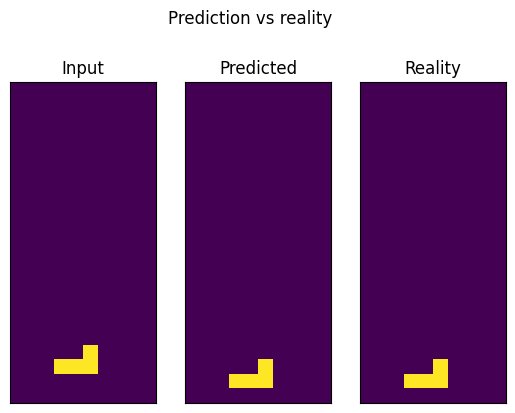

In [56]:
# Show a random training prediction vs reality
import random

idx = random.randrange(len(train_dataset))
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

Showing prediction for test example 35


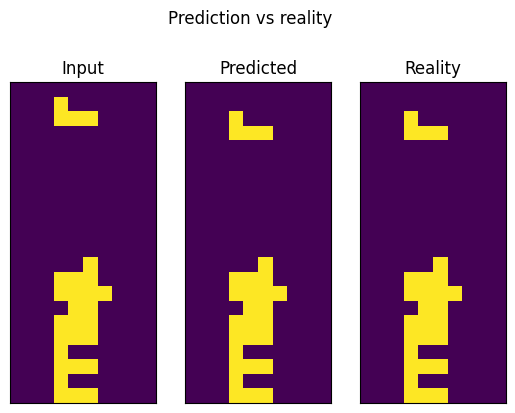

In [34]:
# Show a random test prediction vs reality
idx = random.randrange(len(test_dataset))
print(f"Showing prediction for test example {idx}")
show_prediction(test_dataset[idx])

In [66]:
# Find all examples where prediction failed.

def fails(example):
    x, y = example
    with torch.no_grad():
        preds = model(x.unsqueeze(0)).squeeze(0).argmax(dim=0)
        successes = (preds == y).all(-1).all(-1)
        return not successes.item()
    

def count_failures(dataset):
    failures = []
    for idx, example in enumerate(dataset):
        if fails(example):
            failures.append(idx)
    return len(failures)


print(f"{count_failures(train_dataset)}/{len(train_dataset)} training examples failed in at least one cell.")
print(f"{count_failures(test_dataset)}/{len(test_dataset)} test examples failed in at least one cell.")

4/237 training examples failed in at least one cell.
4/59 test examples failed in at least one cell.


Showing prediction for failed training example 13


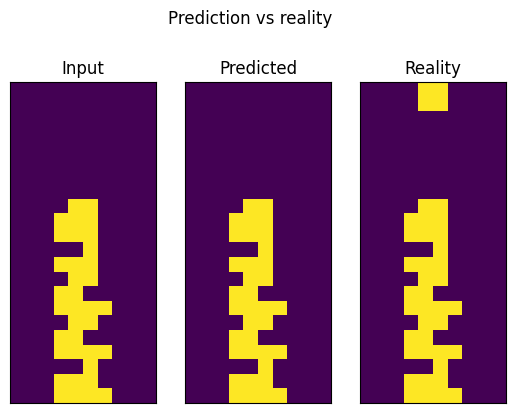

In [73]:
# Show a random failed training prediction vs reality
import itertools

start_idx = random.randrange(len(train_dataset))
for idx in itertools.chain(range(start_idx, len(train_dataset)), range(start_idx)):
    example = train_dataset[idx]
    x, y = example
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).squeeze(0).argmax(0)
        correct = (pred == y).all(-1).all(-1)
    if not correct:
        break

print(f"Showing prediction for failed training example {idx}")
show_prediction(train_dataset[idx])

Showing prediction for failed test example 46


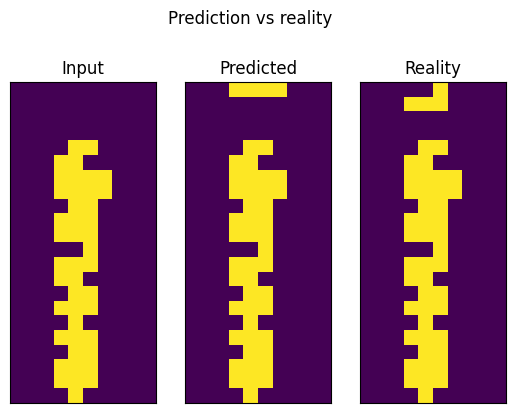

In [85]:
# Show a random failed test prediction vs reality
import itertools

start_idx = random.randrange(len(test_dataset))
for idx in itertools.chain(range(start_idx, len(test_dataset)), range(start_idx)):
    example = test_dataset[idx]
    x, y = example
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).squeeze(0).argmax(0)
        correct = (pred == y).all(-1).all(-1)
    if not correct:
        break

print(f"Showing prediction for failed test example {idx}")
show_prediction(test_dataset[idx])

Even for some of the cases where the model fails to predict the correct block spawn, it still predicts that a block will spawn, just not the correct type.

Here's a thought: how many block spawns does the dataset actually have? How many of each type of block spawn? We expect the model to predict at most 1/6 of block spawns correctly, because the block that spawns is random and so the model has no way of knowing which block will spawn. At best, the model can predict the most common type of block spawn that appears in the dataset.

Let's count the total number of block spawns in the dataset to see what the maximum theoretical accuracy of the model is.

In [101]:
def is_block_spawn(example):
    x, y = example
    return (x[0, :] == 0).all() & (y[0, :] == 1).any()

def describe_block_spawns(dataset):
    num_block_spawns = sum(is_block_spawn(example) for example in dataset)
    frac_block_spawns = num_block_spawns / len(dataset)
    print(f"Dataset has {num_block_spawns} ({frac_block_spawns * 100:.3f}%) block spawns out of {len(train_dataset)} examples.")
    num_block_spawns_per_type = num_block_spawns / 7
    frac_block_spawns_per_type = num_block_spawns_per_type / len(dataset)
    print(f"This implies {num_block_spawns_per_type:.3f} ({frac_block_spawns_per_type * 100:.3f}%) spawns of each type.")
    max_accuracy_without_block_spawns = 1.0 - frac_block_spawns
    print(f"The maximum accuracy while getting all block spawns wrong is {max_accuracy_without_block_spawns * 100:.3f}%")
    max_accuracy_with_block_spawns = max_accuracy_without_block_spawns + frac_block_spawns_per_type
    print(f"The maximum accuracy while getting one type of block spawn right is {max_accuracy_with_block_spawns * 100:.3f}%")

print("Describing training dataset...")
describe_block_spawns(train_dataset)
print()
print("Describing test dataset...")
describe_block_spawns(test_dataset)

Describing training dataset...
Dataset has 9 (3.797%) block spawns out of 237 examples.
This implies 1.286 (0.542%) spawns of each type.
The maximum accuracy while getting all block spawns wrong is 96.203%
The maximum accuracy while getting one type of block spawn right is 96.745%

Describing test dataset...
Dataset has 5 (8.475%) block spawns out of 237 examples.
This implies 0.714 (1.211%) spawns of each type.
The maximum accuracy while getting all block spawns wrong is 91.525%
The maximum accuracy while getting one type of block spawn right is 92.736%


Now let's actually count the different types of spawns to get more precise bounds on the accuracy.

In [111]:
class BlockType:
    I = 0
    O = 1
    T = 2
    Z = 3
    S = 4
    J = 5
    L = 6
    
def get_block_spawn_type(example):
    x, y = example
    if (x[0, :] == 1).any() | (y[0, :] == 0).all():
        return None
    if (y[1, :] == 0).all():
        return BlockType.I
    if y[0, 3] == 1:
        if y[1, 3] == 1:
            return BlockType.J
        else:
            if y[0, 5] == 1:
                return BlockType.T
            else:
                return BlockType.Z
    else:
        if y[1, 3] == 1:
            if y[0, 4] == 1:
                return BlockType.S
            else:
                return BlockType.L
        else:
            return BlockType.O


def count_block_spawns_by_type(dataset):
    spawns_by_type = {}
    for example in dataset:
        spawn_type = get_block_spawn_type(example)
        spawn_type_count = spawns_by_type.get(spawn_type, 0) + 1
        spawns_by_type[spawn_type] = spawn_type_count
    return spawns_by_type


def describe_block_spawns(dataset):
    spawns_by_type = count_block_spawns_by_type(dataset)
    print(spawns_by_type)
    
    num_block_spawns = sum(val for key, val in spawns_by_type.items() if key is not None)
    frac_block_spawns = num_block_spawns / len(dataset)
    print(f"Dataset has {num_block_spawns} ({frac_block_spawns * 100:.3f}%) block spawns out of {len(train_dataset)} examples.")
    highest_freq = max(val for key, val in spawns_by_type.items() if key is not None)
    highest_frac = highest_freq / len(dataset)
    print(f"The most common block spawn occurs {highest_freq} ({highest_frac * 100:.3f}%) times.")
    max_accuracy_without_block_spawns = 1.0 - frac_block_spawns
    print(f"The maximum accuracy while getting all block spawns wrong is {max_accuracy_without_block_spawns * 100:.3f}%")
    max_accuracy_with_block_spawns = max_accuracy_without_block_spawns + highest_frac
    print(f"The maximum accuracy while predicting the most common block spawn right is {max_accuracy_with_block_spawns * 100:.3f}%")

print("Describing training dataset...")
describe_block_spawns(train_dataset)
print()
print("Describing test dataset...")
describe_block_spawns(test_dataset)

Describing training dataset...
{None: 228, 1: 1, 4: 3, 0: 3, 5: 1, 6: 1}
Dataset has 9 (3.797%) block spawns out of 237 examples.
The most common block spawn occurs 3 (1.266%) times.
The maximum accuracy while getting all block spawns wrong is 96.203%
The maximum accuracy while predicting the most common block spawn right is 97.468%

Describing test dataset...
{None: 54, 1: 1, 2: 2, 6: 1, 0: 1}
Dataset has 5 (8.475%) block spawns out of 237 examples.
The most common block spawn occurs 2 (3.390%) times.
The maximum accuracy while getting all block spawns wrong is 91.525%
The maximum accuracy while predicting the most common block spawn right is 94.915%


The maximum accuracy values for the models that incorporate block landing prediction are very close to these theoretical values! This confirms that we cannot push the accuracy higher because of the inherent randomness in the choice of which block spawns next.

Now let's find all the examples of block spawns in the dataset and show the model's predictions on each.

Block spawn indices: [13, 81, 95, 99, 133, 202, 207, 217, 234]


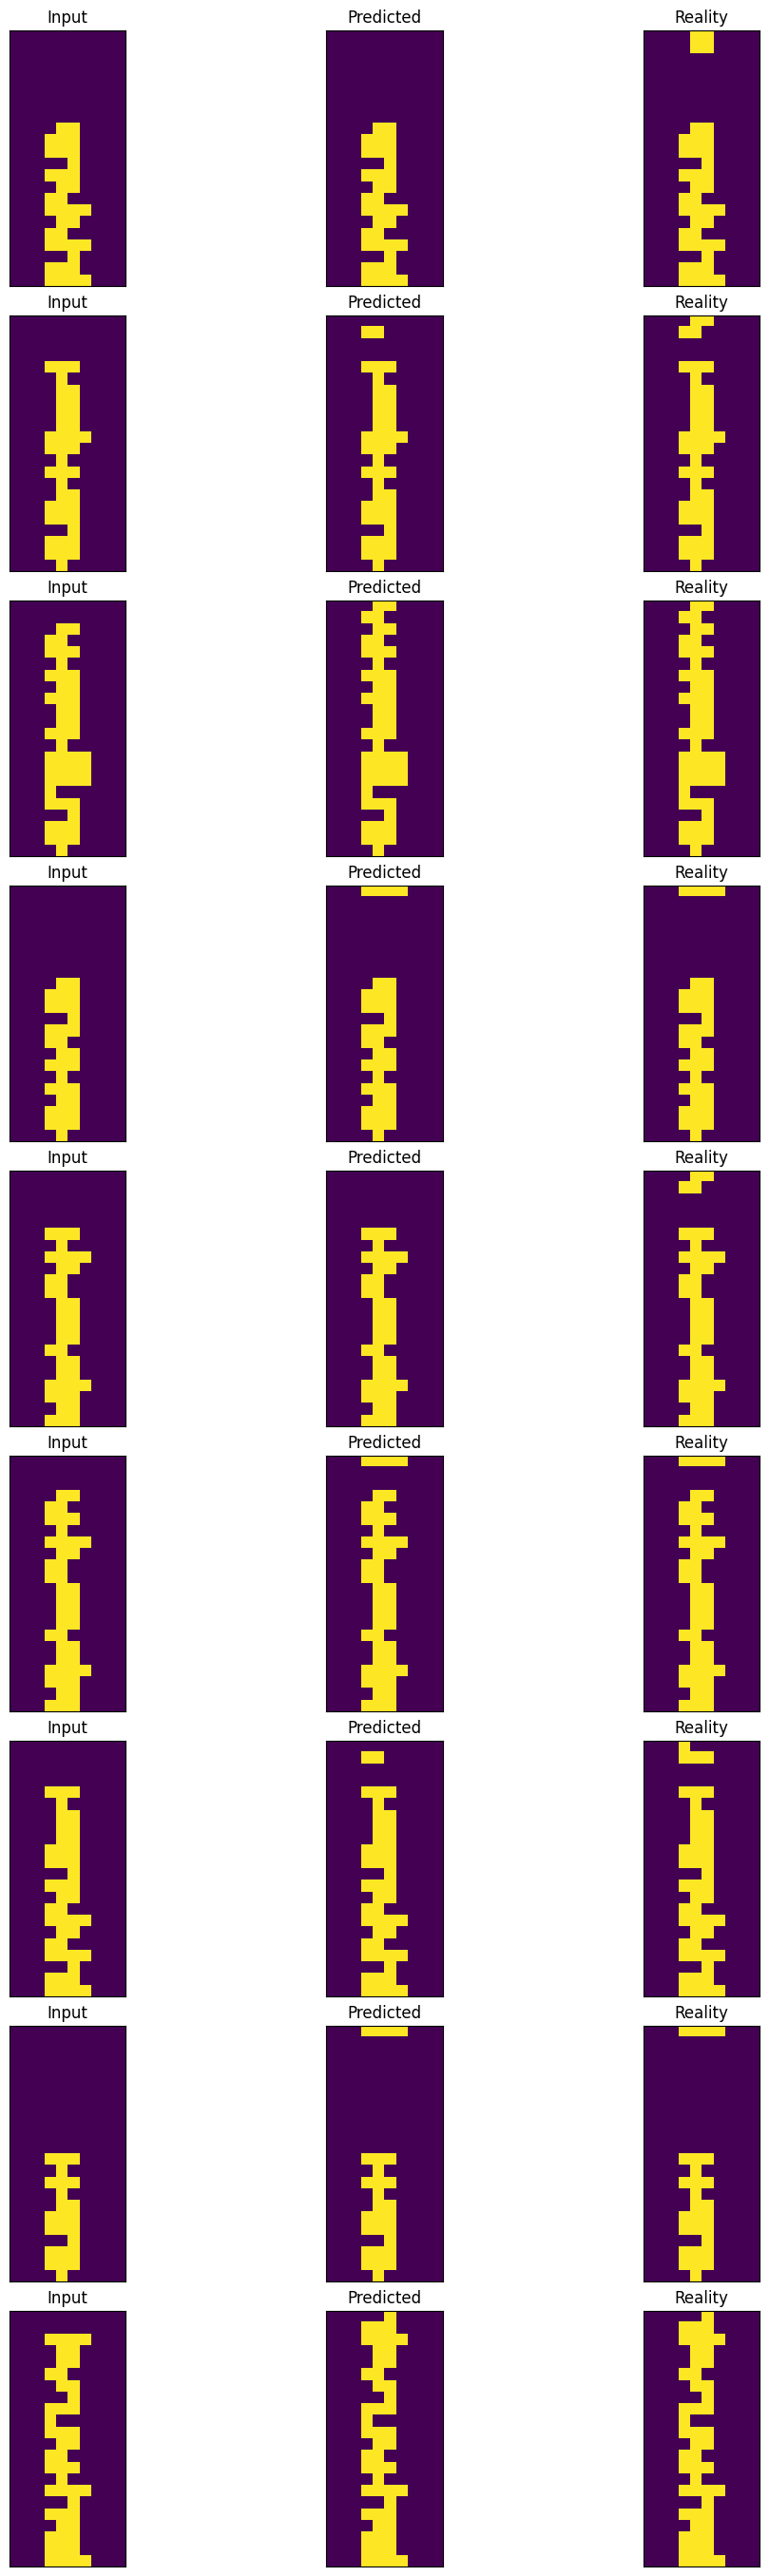

In [109]:
def show_block_spawn_predictions(model, dataset):
    block_spawns_indices = [idx for idx in range(len(dataset)) if is_block_spawn(dataset[idx])]
    print(f"Block spawn indices: {block_spawns_indices}")
    fig, axs = plt.subplots(len(block_spawns_indices), 3, figsize=(10, 3 * len(block_spawns_indices)), constrained_layout=True)
    for ax in axs.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    for i in range(len(block_spawns_indices)):
        x, y = dataset[block_spawns_indices[i]]
        with torch.no_grad():
            pred = model(x.unsqueeze(0)).squeeze(0).argmax(0)
        axs[i, 0].imshow(x)
        axs[i, 0].set_title("Input")
        axs[i, 1].imshow(pred)
        axs[i, 1].set_title("Predicted")
        axs[i, 2].imshow(y)
        axs[i, 2].set_title("Reality")

show_block_spawn_predictions(model, train_dataset)

Block spawn indices: [1, 13, 46, 49, 50]


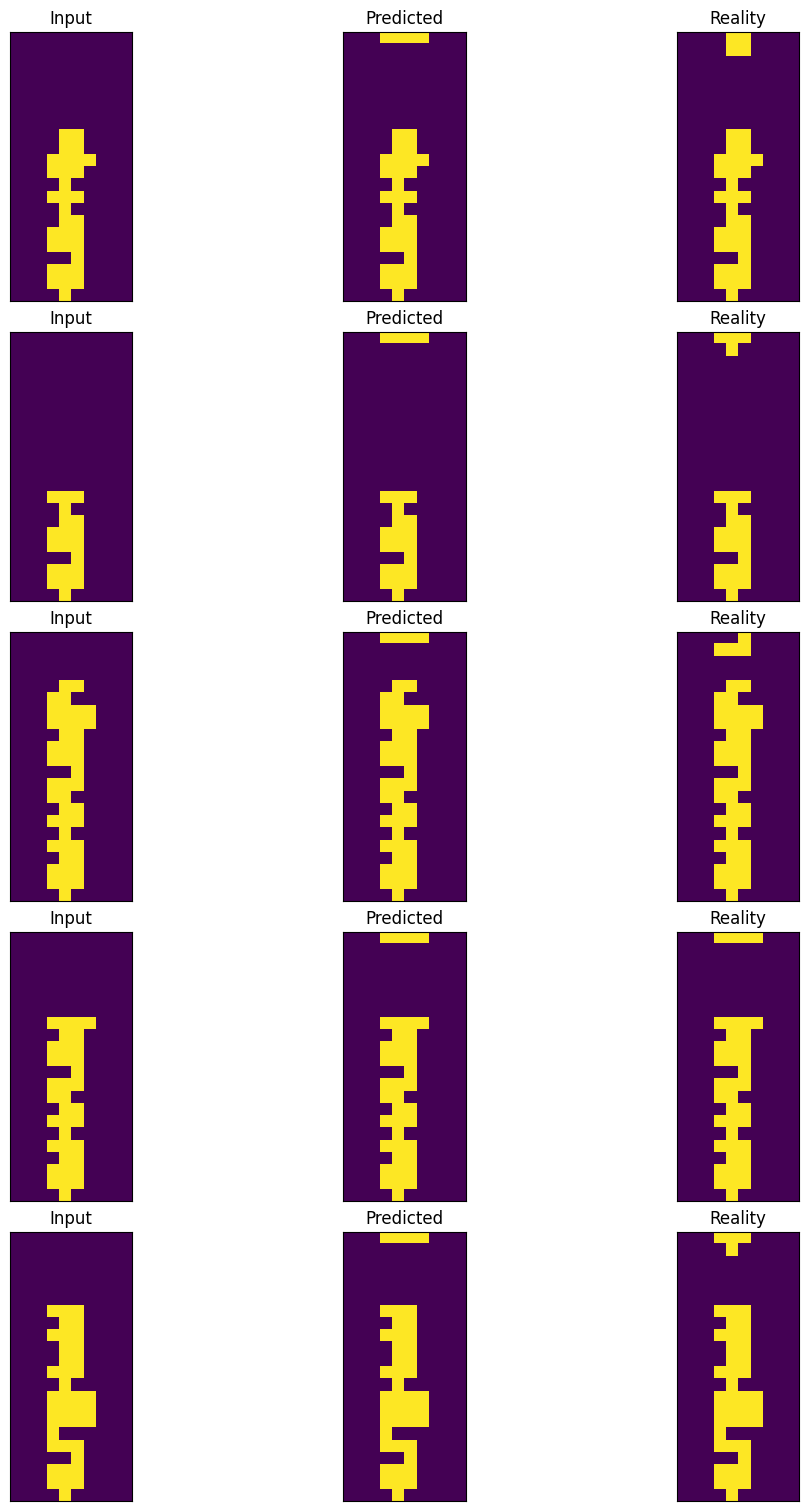

In [110]:
show_block_spawn_predictions(model, test_dataset)

From this we see that the model indeed prefers to predict the most common type of block spawn, which is I for this dataset. In several of the cases where the prediction was incorrect on the test set, the model actually did predict a block spawn, but it predicted type I whereas the real block that spawned was of a different type. We also see that the model predicts other types of spawns on the training set, which suggests that the model is overfitting slightly, because there is no way the model can know which type of block is going to spawn. The model also misses some spawns entirely, which could be a sign of underfitting. However, the model does not miss any block spawns of type I, which suggests that the training process is sufficient to correct for missed spawns when they match the model's preferred type of spawn, but insufficient otherwise.